ModuleNotFoundError: No module named 'torch'

In [1]:
pip install torch torchvision torchaudio


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
image_size = 64
nz = 100  # Noise dim
num_classes = 10
embedding_dim = 50
ngf = 64
ndf = 64
num_epochs = 10

# DataLoader
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [3]:
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz + embedding_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)  # (B, embedding_dim)
        x = torch.cat([noise, label_embedding], 1).unsqueeze(2).unsqueeze(3)  # (B, nz+embed, 1, 1)
        return self.model(x)


In [4]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Conv2d(1 + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
      label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
      label_map = label_embedding.repeat(1, 1, img.size(2), img.size(3))
      label_map = label_map[:, 0:1, :, :]
      x = torch.cat([img, label_map], dim=1)
      out = self.model(x)  # shape: (B, 1, H', W')

      # ✅ Instead of view(-1), do global averaging:
      return out.mean([2, 3]).squeeze(1)  # shape: (B,)



In [5]:
netG = ConditionalGenerator().to(device)
netD = ConditionalDiscriminator().to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


Epoch [1/10] Step [0] Loss_D: 1.2828 Loss_G: 1.7349
Epoch [1/10] Step [100] Loss_D: 0.0166 Loss_G: 4.9801
Epoch [1/10] Step [200] Loss_D: 0.0044 Loss_G: 6.9140
Epoch [1/10] Step [300] Loss_D: 0.0024 Loss_G: 7.1509
Epoch [1/10] Step [400] Loss_D: 0.0015 Loss_G: 7.3548

✅ Epoch [1] Completed - Avg D Loss: 0.0412, Avg G Loss: 6.3254
🔍 Calculating FID...
📊 FID Score for Epoch 1: 360.86

Epoch [2/10] Step [0] Loss_D: 0.0009 Loss_G: 8.0029
Epoch [2/10] Step [100] Loss_D: 0.0006 Loss_G: 8.2858
Epoch [2/10] Step [200] Loss_D: 0.0005 Loss_G: 8.4265
Epoch [2/10] Step [300] Loss_D: 0.0004 Loss_G: 9.3870
Epoch [2/10] Step [400] Loss_D: 0.0003 Loss_G: 8.9851

✅ Epoch [2] Completed - Avg D Loss: 0.0005, Avg G Loss: 8.8083
🔍 Calculating FID...
📊 FID Score for Epoch 2: 276.34

Epoch [3/10] Step [0] Loss_D: 0.0004 Loss_G: 8.7929
Epoch [3/10] Step [100] Loss_D: 0.0002 Loss_G: 9.4935
Epoch [3/10] Step [200] Loss_D: 0.0002 Loss_G: 10.2929
Epoch [3/10] Step [300] Loss_D: 0.0001 Loss_G: 10.4168
Epoch [3/10]

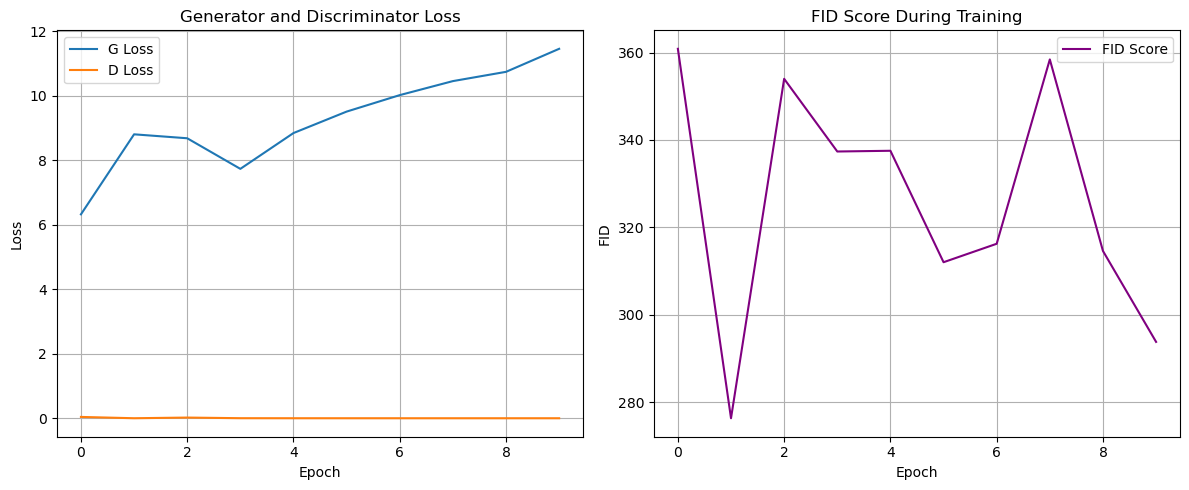

In [6]:
import os
import torch
from torchvision.utils import save_image
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import subprocess

# Assume these are defined
# netG, netD, optimizerG, optimizerD, criterion, dataloader, num_epochs, device, nz, num_classes

G_losses = []
D_losses = []
FID_scores = []

def save_images_for_fid(netG, dataloader, epoch, device, nz, num_classes):
    real_dir = f"fid_tmp/real_{epoch}"
    fake_dir = f"fid_tmp/fake_{epoch}"
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)

    # Save real images (first 1000)
    count = 0
    for imgs, _ in dataloader:
        for img in imgs:
            if img.size(0) == 1:
                img = img.repeat(3, 1, 1)
            save_image(img, f"{real_dir}/real_{count}.png")
            count += 1
            if count >= 1000: break
        if count >= 1000: break

    # Generate and save fake images
    netG.eval()
    count = 0
    with torch.no_grad():
        for _ in range(1000 // 64):
            noise = torch.randn(64, nz, device=device)
            labels = torch.randint(0, num_classes, (64,), device=device)
            fake_imgs = netG(noise, labels)
            for img in fake_imgs:
                img = img.cpu()
                if img.size(0) == 1:
                    img = img.repeat(3, 1, 1)
                save_image(img, f"{fake_dir}/fake_{count}.png")
                count += 1
                if count >= 1000: break
            if count >= 1000: break

    return real_dir, fake_dir

for epoch in range(num_epochs):
    netG.train()
    netD.train()
    running_loss_G = 0.0
    running_loss_D = 0.0
    num_batches = 0

    for i, (real_imgs, labels) in enumerate(dataloader):
        b_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)

        ############################
        # Train Discriminator
        ############################
        netD.zero_grad()
        label_real = torch.full((b_size,), 1.0, device=device)
        output_real = netD(real_imgs, labels)
        loss_real = criterion(output_real, label_real)

        noise = torch.randn(b_size, nz, device=device)
        fake_imgs = netG(noise, labels)
        label_fake = torch.full((b_size,), 0.0, device=device)
        output_fake = netD(fake_imgs.detach(), labels)
        loss_fake = criterion(output_fake, label_fake)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        ############################
        # Train Generator
        ############################
        netG.zero_grad()
        label_gen = torch.full((b_size,), 1.0, device=device)
        output = netD(fake_imgs, labels)
        loss_G = criterion(output, label_gen)
        loss_G.backward()
        optimizerG.step()

        running_loss_D += loss_D.item()
        running_loss_G += loss_G.item()
        num_batches += 1

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

    avg_D = running_loss_D / num_batches
    avg_G = running_loss_G / num_batches
    D_losses.append(avg_D)
    G_losses.append(avg_G)

    print(f"\n✅ Epoch [{epoch+1}] Completed - Avg D Loss: {avg_D:.4f}, Avg G Loss: {avg_G:.4f}")

    # FID Calculation
    print("🔍 Calculating FID...")
    real_path, fake_path = save_images_for_fid(netG, dataloader, epoch, device, nz, num_classes)
    fid_cmd = f"python -m pytorch_fid {real_path} {fake_path}"
    result = subprocess.run(fid_cmd.split(), capture_output=True, text=True)

    try:
        fid_value = float(result.stdout.strip().split()[-1])
        FID_scores.append(fid_value)
        print(f"📊 FID Score for Epoch {epoch+1}: {fid_value:.2f}\n")
    except:
        print("❌ Failed to parse FID score!")
        FID_scores.append(None)

# -----------------------------
# 📈 Plotting Results
# -----------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Generator and Discriminator Loss")
plt.plot(G_losses, label="G Loss")
plt.plot(D_losses, label="D Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("FID Score During Training")
plt.plot(FID_scores, label="FID Score", color="purple")
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
pip install pytorch-fid


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import torch
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image

# Setup paths
real_path = "fid_images/real"
fake_path = "fid_images/fake"
os.makedirs(real_path, exist_ok=True)
os.makedirs(fake_path, exist_ok=True)

# Image transformation
to_pil = transforms.ToPILImage()

# Save Real Images
print("Saving real images...")
for i, (imgs, _) in enumerate(tqdm(dataloader)):
    for j in range(imgs.size(0)):
        img = imgs[j].cpu()
        if img.size(0) == 1:  # Grayscale to RGB
            img = img.repeat(3, 1, 1)
        to_pil(img).save(f"{real_path}/real_{i * imgs.size(0) + j}.png")
    if i * imgs.size(0) > 1000:
        break

# Generate Fake Images
print("Generating and saving fake images...")
netG.eval()
num_fake = 1000
b_size = 64  # Or your actual batch size
with torch.no_grad():
    for i in tqdm(range(num_fake // b_size)):
        noise = torch.randn(b_size, nz, device=device)
        
        # Generate random labels (or use from dataset if available)
        fake_labels = torch.randint(0, num_classes, (b_size,), device=device)

        fake_imgs = netG(noise, fake_labels)

        for j in range(fake_imgs.size(0)):
            img = fake_imgs[j].cpu()
            if img.size(0) == 1:
                img = img.repeat(3, 1, 1)
            to_pil(img).save(f"{fake_path}/fake_{i * b_size + j}.png")

# Compute FID (requires pytorch-fid to be installed)
# Run this from terminal/command line:
# python -m pytorch_fid fid_images/real fid_images/fake


Saving real images...


  2%|▏         | 8/469 [00:04<04:23,  1.75it/s]


Generating and saving fake images...


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


More Refined

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm

class ConditionalGenerator(nn.Module):
    def __init__(self, num_classes, embedding_dim, nz, ngf):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        # Define the layers of the generator with LeakyReLU and Spectral Normalization
        self.model = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(nz + embedding_dim, ngf * 8, 4, 1, 0, bias=False)),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.ConvTranspose2d(ngf * 2, 1, 4, 2, 1, bias=False)),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Embedding labels and concatenate with noise
        label_embedding = self.label_emb(labels)  # (B, embedding_dim)
        x = torch.cat([noise, label_embedding], 1).unsqueeze(2).unsqueeze(3)  # (B, nz+embed, 1, 1)
        return self.model(x)


In [29]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim, ndf):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        # Update input channels to be 1 (image) + embedding_dim (label)
        self.model = nn.Sequential(
            nn.Conv2d(1 + embedding_dim, ndf, 4, 2, 1, bias=False),  # 1 + embedding_dim
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embed the labels and reshape them to match the image size
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        
        # Repeat the label embedding to match the spatial size of the image
        label_map = label_embedding.repeat(1, 1, img.size(2), img.size(3))
        
        # Concatenate the image and label map along the channel dimension
        x = torch.cat([img, label_map], dim=1)

        # Output from the model
        out = self.model(x)  # shape: (B, 1, H', W')

        # Use global average pooling instead of flattening:
        return out.mean([2, 3]).squeeze(1)  # shape: (B,)


In [30]:
from scipy.linalg import sqrtm
import numpy as np
import torch
from torch.utils.data import DataLoader

def calculate_fid(generator, dataloader, device, num_samples=1000):
    """Calculate FID score for the generated images"""
    real_features = []
    fake_features = []
    
    # Use a pre-trained model (like InceptionV3) to extract features
    inception_model = InceptionV3().to(device)  # Replace with actual model

    # Collect features from real images
    with torch.no_grad():
        for i, (real_imgs, labels) in enumerate(dataloader):
            if i * dataloader.batch_size >= num_samples:
                break
            real_imgs = real_imgs.to(device)
            real_features.append(inception_model(real_imgs).cpu().numpy())
    
    # Collect features from fake images
    with torch.no_grad():
        noise = torch.randn(num_samples, 100, device=device)
        fake_imgs = generator(noise, labels).cpu().detach().numpy()
        fake_features.append(inception_model(fake_imgs).cpu().numpy())

    # Compute FID score
    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)
    
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    
    # Compute the Frechet distance
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    
    return fid


In [31]:
from scipy.linalg import sqrtm
import numpy as np
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch import nn

# InceptionV3 model for FID calculation
class InceptionV3(nn.Module):
    def __init__(self, device):
        super(InceptionV3, self).__init__()
        # Load pre-trained InceptionV3 model
        self.model = models.inception_v3(pretrained=True, transform_input=False).to(device)
        self.model.eval()  # Set to evaluation mode

    def forward(self, x):
        return self.model(x)

def calculate_fid(generator, dataloader, device, num_samples=1000):
    """Calculate FID score for the generated images"""
    real_features = []
    fake_features = []
    
    # Initialize InceptionV3 model
    inception_model = InceptionV3(device)
    
    # Define image transformation (resize and normalization)
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Collect features from real images
    with torch.no_grad():
        for i, (real_imgs, labels) in enumerate(dataloader):
            if i * dataloader.batch_size >= num_samples:
                break
            real_imgs = real_imgs.to(device)
            real_imgs = torch.stack([transform(img) for img in real_imgs])  # Apply transform to each image
            real_features.append(inception_model(real_imgs).cpu().numpy())
    
    # Collect features from fake images
    with torch.no_grad():
        noise = torch.randn(num_samples, 100, device=device)
        fake_imgs = generator(noise, labels).cpu().detach().numpy()
        fake_imgs = torch.stack([transform(img) for img in fake_imgs])  # Apply transform to each fake image
        fake_features.append(inception_model(fake_imgs).cpu().numpy())

    # Compute FID score
    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)
    
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    
    # Compute the Frechet distance
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    
    return fid


In [32]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models.inception import inception_v3
from scipy.linalg import sqrtm

# Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, num_classes, embedding_dim, nz, ngf):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        self.model = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(nz + embedding_dim, ngf * 8, 4, 1, 0, bias=False)),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.ConvTranspose2d(ngf * 2, 3, 4, 2, 1, bias=False)),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([noise, label_embedding], 1).unsqueeze(2).unsqueeze(3)
        return self.model(x)

# Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim, ndf, in_channels=3):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.in_channels = in_channels

        self.model = nn.Sequential(
            nn.Conv2d(in_channels + embedding_dim, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_map = label_embedding.repeat(1, 1, img.size(2), img.size(3))
        x = torch.cat([img, label_map], dim=1)
        out = self.model(x)
        return out.mean([2, 3]).squeeze(1)

# Initialize InceptionV3 for FID
inception = inception_v3(pretrained=True, transform_input=False).cuda()
inception.eval()
inception.fc = nn.Identity()  # We'll use the penultimate layer features

def get_inception_features(x):
    x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
    x = (x + 1) / 2  # Scale from [-1,1] to [0,1]
    return inception(x)

def calculate_fid(real_imgs, fake_imgs):
    # Get features
    real_features = get_inception_features(real_imgs).cpu().detach().numpy()
    fake_features = get_inception_features(fake_imgs).cpu().detach().numpy()
    
    # Calculate statistics
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    
    # Calculate FID
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# Training setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nz = 100
ngf = 64
ndf = 64
num_classes = 10
embedding_dim = 50
lr = 0.0002
beta1 = 0.5
num_epochs = 10
batch_size = 64

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataloader = DataLoader(
    datasets.CIFAR10(root='data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

netG = ConditionalGenerator(num_classes, embedding_dim, nz, ngf).to(device)
netD = ConditionalDiscriminator(num_classes, embedding_dim, ndf, in_channels=3).to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
fixed_noise = torch.randn(64, nz, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)

for epoch in range(num_epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        batch_size = real_imgs.size(0)
        
        # Train Discriminator
        netD.zero_grad()
        noise = torch.randn(batch_size, nz, device=device)
        fake_imgs = netG(noise, labels)
        
        real_output = netD(real_imgs, labels)
        fake_output = netD(fake_imgs.detach(), labels)
        
        loss_real = criterion(real_output, torch.ones_like(real_output))
        loss_fake = criterion(fake_output, torch.zeros_like(fake_output))
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizerD.step()
        
        # Train Generator
        netG.zero_grad()
        output = netD(fake_imgs, labels)
        loss_G = criterion(output, torch.ones_like(output))
        loss_G.backward()
        optimizerG.step()
        
    # Calculate FID
    with torch.no_grad():
        fake_imgs = netG(fixed_noise, fixed_labels)
        fid = calculate_fid(real_imgs[:64], fake_imgs)
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f} FID: {fid:.2f}')

Epoch [1/10] Loss_D: 0.0001 Loss_G: 10.0574 FID: 427.54
Epoch [2/10] Loss_D: 0.0000 Loss_G: 11.5366 FID: 423.84
Epoch [3/10] Loss_D: 0.0000 Loss_G: 12.3268 FID: 432.58
Epoch [4/10] Loss_D: 0.0000 Loss_G: 12.8136 FID: 405.14
Epoch [5/10] Loss_D: 0.0000 Loss_G: 12.8556 FID: 408.65
Epoch [6/10] Loss_D: 0.0000 Loss_G: 14.1960 FID: 416.88
Epoch [7/10] Loss_D: 0.0000 Loss_G: 14.2821 FID: 414.89
Epoch [8/10] Loss_D: 0.0000 Loss_G: 15.0643 FID: 437.30
Epoch [9/10] Loss_D: 0.0000 Loss_G: 15.5582 FID: 416.57
Epoch [10/10] Loss_D: 0.0000 Loss_G: 15.5539 FID: 407.70


/home/vpadole/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vpadole/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 782/782 [00:17<00:00, 43.53it/s]



Epoch 1 | D Loss: 0.0089 | G Loss: 8.3681 | FID: 423.64


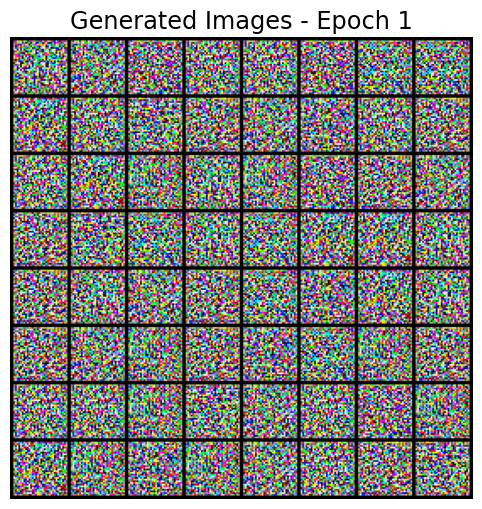

Epoch 2: 100%|██████████| 782/782 [00:17<00:00, 43.50it/s]



Epoch 2 | D Loss: 0.0000 | G Loss: 11.0357 | FID: 394.87


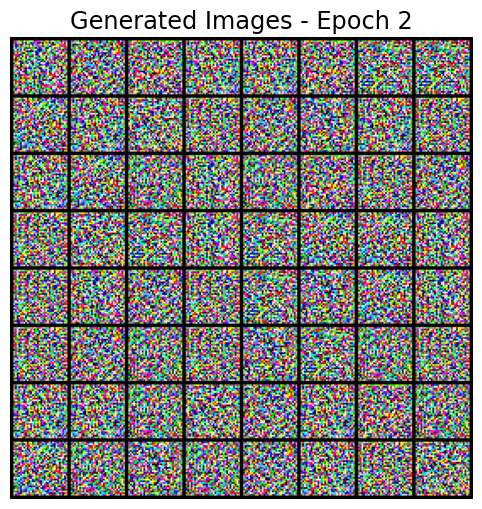

Epoch 3: 100%|██████████| 782/782 [00:17<00:00, 43.49it/s]



Epoch 3 | D Loss: 0.0000 | G Loss: 12.0578 | FID: 474.96


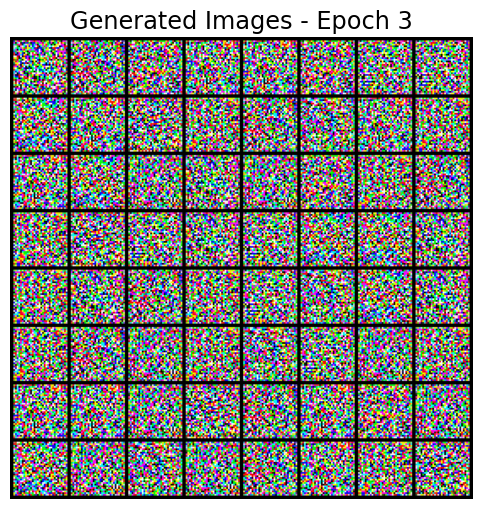

Epoch 4: 100%|██████████| 782/782 [00:18<00:00, 43.40it/s]



Epoch 4 | D Loss: 0.0000 | G Loss: 12.7775 | FID: 429.90


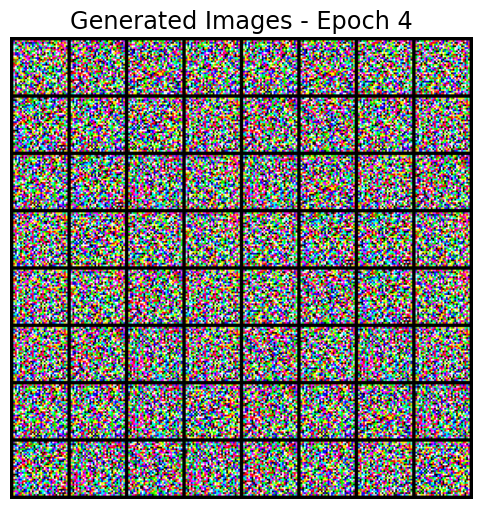

Epoch 5: 100%|██████████| 782/782 [00:17<00:00, 43.54it/s]



Epoch 5 | D Loss: 0.0000 | G Loss: 13.3652 | FID: 467.68


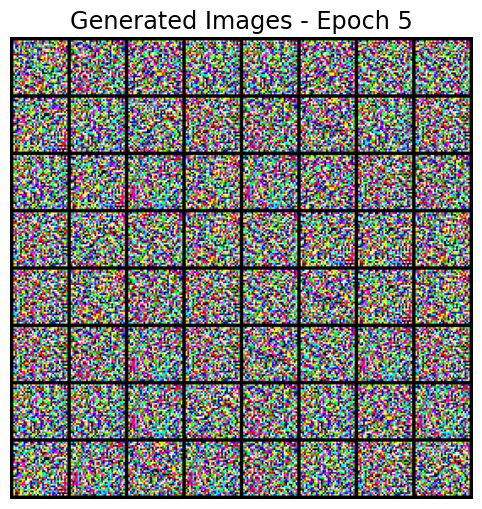

Epoch 6: 100%|██████████| 782/782 [00:18<00:00, 43.37it/s]



Epoch 6 | D Loss: 0.0000 | G Loss: 13.8960 | FID: 404.37


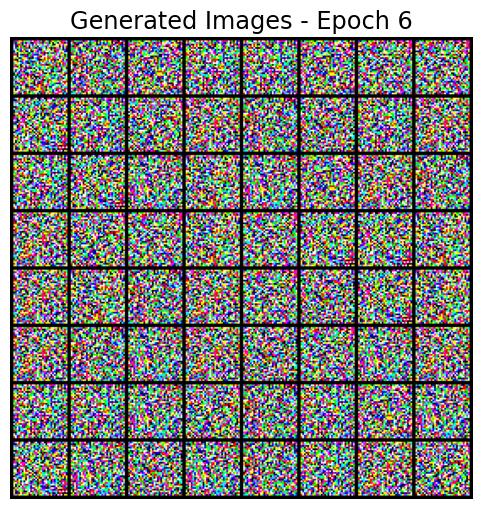

Epoch 7: 100%|██████████| 782/782 [00:17<00:00, 43.58it/s]



Epoch 7 | D Loss: 0.0000 | G Loss: 14.3775 | FID: 396.26


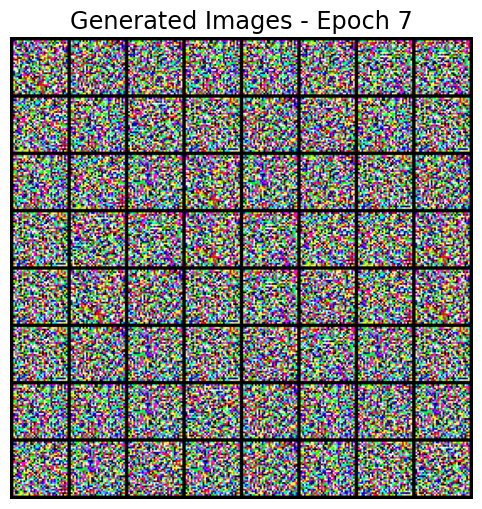

Epoch 8: 100%|██████████| 782/782 [00:17<00:00, 43.49it/s]



Epoch 8 | D Loss: 0.0000 | G Loss: 14.8433 | FID: 433.35


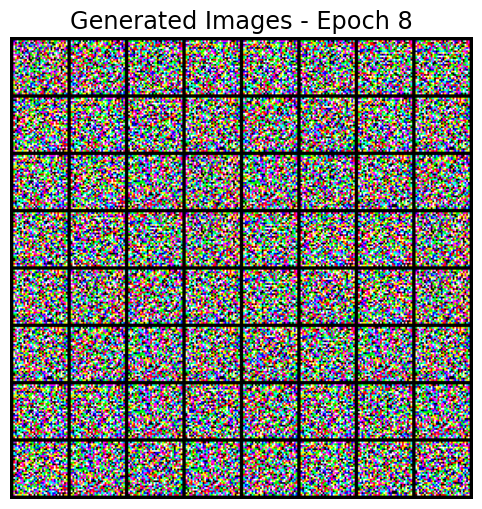

Epoch 9: 100%|██████████| 782/782 [00:18<00:00, 43.44it/s]



Epoch 9 | D Loss: 0.0000 | G Loss: 15.2926 | FID: 436.83


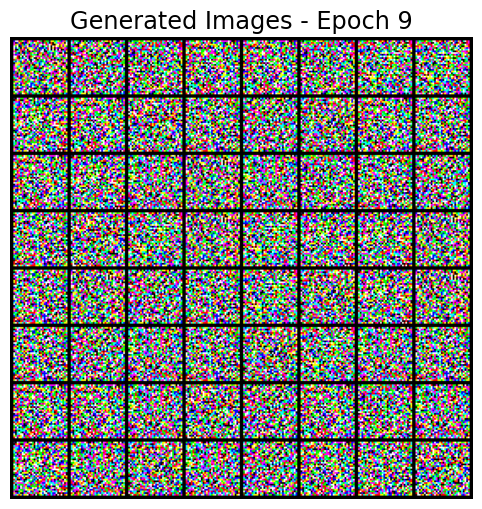

Epoch 10: 100%|██████████| 782/782 [00:17<00:00, 43.61it/s]



Epoch 10 | D Loss: 0.0000 | G Loss: 15.7418 | FID: 422.07


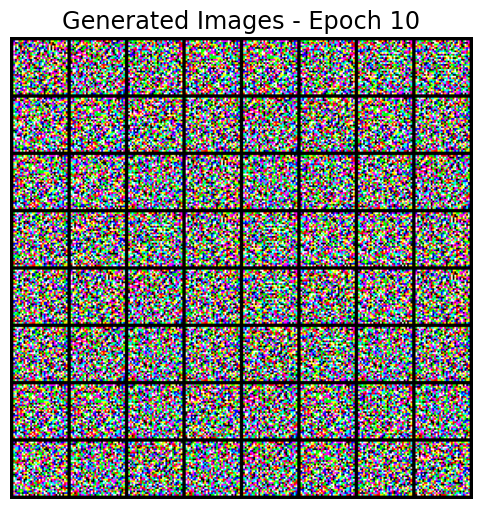

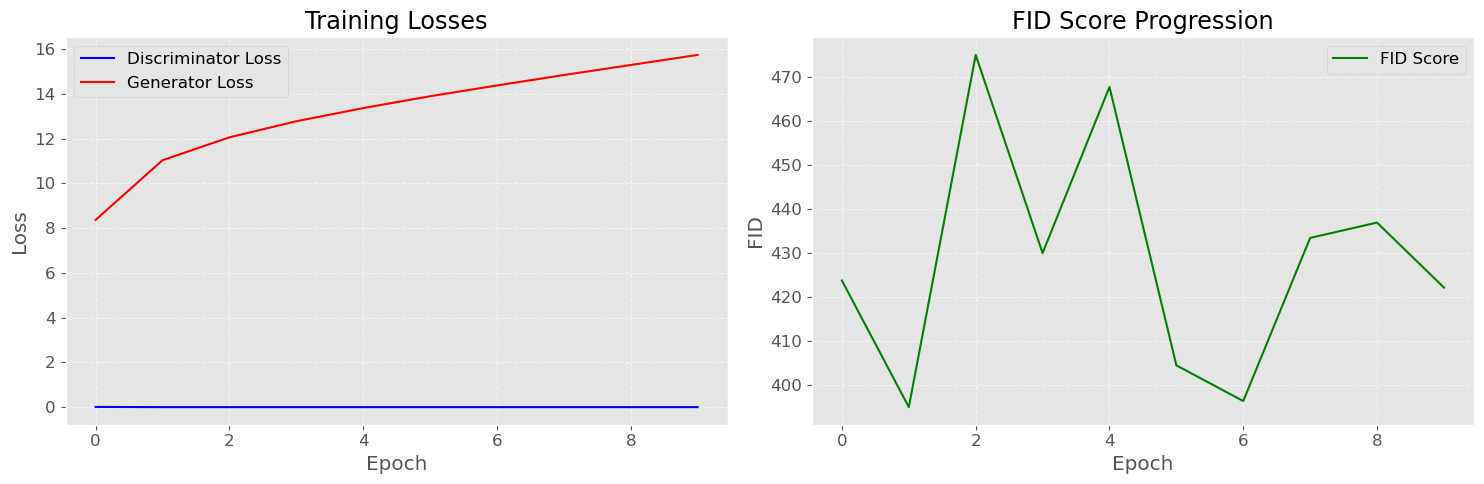

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models.inception import inception_v3
from scipy.linalg import sqrtm
import torchvision

# Set up matplotlib styles
plt.style.use('ggplot')  # Using 'ggplot' style instead of 'seaborn'
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Generator (same as before)
class ConditionalGenerator(nn.Module):
    def __init__(self, num_classes, embedding_dim, nz, ngf):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        self.model = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(nz + embedding_dim, ngf * 8, 4, 1, 0, bias=False)),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.ConvTranspose2d(ngf * 2, 3, 4, 2, 1, bias=False)),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([noise, label_embedding], 1).unsqueeze(2).unsqueeze(3)
        return self.model(x)

# Discriminator (same as before)
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim, ndf, in_channels=3):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.in_channels = in_channels

        self.model = nn.Sequential(
            nn.Conv2d(in_channels + embedding_dim, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_map = label_embedding.repeat(1, 1, img.size(2), img.size(3))
        x = torch.cat([img, label_map], dim=1)
        out = self.model(x)
        return out.mean([2, 3]).squeeze(1)

# Initialize InceptionV3 for FID
inception = inception_v3(pretrained=True, transform_input=False).cuda()
inception.eval()
inception.fc = nn.Identity()

def get_inception_features(x):
    x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
    x = (x + 1) / 2  # Scale from [-1,1] to [0,1]
    return inception(x)

def calculate_fid(real_imgs, fake_imgs):
    real_features = get_inception_features(real_imgs).cpu().detach().numpy()
    fake_features = get_inception_features(fake_imgs).cpu().detach().numpy()
    
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# Training Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nz = 100
ngf = 64
ndf = 64
num_classes = 10
embedding_dim = 50
lr = 0.0002
beta1 = 0.5
num_epochs = 10
batch_size = 64

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataloader = DataLoader(
    datasets.CIFAR10(root='data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

netG = ConditionalGenerator(num_classes, embedding_dim, nz, ngf).to(device)
netD = ConditionalDiscriminator(num_classes, embedding_dim, ndf, in_channels=3).to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Tracking
losses_d = []
losses_g = []
fids = []
fixed_noise = torch.randn(64, nz, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)

# Training Loop
for epoch in range(num_epochs):
    epoch_loss_d = 0
    epoch_loss_g = 0
    
    for i, (real_imgs, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}")):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        batch_size = real_imgs.size(0)
        
        # Train Discriminator
        netD.zero_grad()
        noise = torch.randn(batch_size, nz, device=device)
        fake_imgs = netG(noise, labels)
        
        real_output = netD(real_imgs, labels)
        fake_output = netD(fake_imgs.detach(), labels)
        
        loss_real = criterion(real_output, torch.ones_like(real_output))
        loss_fake = criterion(fake_output, torch.zeros_like(fake_output))
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizerD.step()
        
        # Train Generator
        netG.zero_grad()
        output = netD(fake_imgs, labels)
        loss_G = criterion(output, torch.ones_like(output))
        loss_G.backward()
        optimizerG.step()
        
        epoch_loss_d += loss_D.item()
        epoch_loss_g += loss_G.item()
    
    # Calculate metrics
    avg_loss_d = epoch_loss_d / len(dataloader)
    avg_loss_g = epoch_loss_g / len(dataloader)
    losses_d.append(avg_loss_d)
    losses_g.append(avg_loss_g)
    
    with torch.no_grad():
        fake_imgs = netG(fixed_noise, fixed_labels)
        fid = calculate_fid(real_imgs[:64], fake_imgs)
        fids.append(fid)
        print(f"\nEpoch {epoch+1} | D Loss: {avg_loss_d:.4f} | G Loss: {avg_loss_g:.4f} | FID: {fid:.2f}")
        
        # Plot sample images
        fake = (fake_imgs.detach().cpu() + 1) / 2
        grid = torchvision.utils.make_grid(fake, nrow=8)
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.title(f"Generated Images - Epoch {epoch+1}")
        plt.axis('off')
        plt.show()

# Final Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(losses_d, 'b-', label='Discriminator Loss')
ax1.plot(losses_g, 'r-', label='Generator Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Losses')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# FID plot
ax2.plot(fids, 'g-', label='FID Score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('FID')
ax2.set_title('FID Score Progression')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Save models
torch.save(netG.state_dict(), 'conditional_generator.pth')
torch.save(netD.state_dict(), 'conditional_discriminator.pth')